In [1]:
!pip install -e C:\Users\asus_strix_scar\Anaconda3\Lib\site-packages\gym\envs\steering-optimizer\steering_optimizer\envs\github\steering-optimizer\

Obtaining file:///C:/Users/asus_strix_scar/Anaconda3/Lib/site-packages/gym/envs/steering-optimizer/steering_optimizer/envs/github/steering-optimizer
  Found existing installation: steering-optimizer 0.0.1
    Uninstalling steering-optimizer-0.0.1:
      Successfully uninstalled steering-optimizer-0.0.1
  Running setup.py develop for steering-optimizer


In [2]:
import numpy as np

In [3]:
import gym

In [4]:
#Deleting registered environment

for env in gym.envs.registry.env_specs.keys():
     if 'steering_optimizer' in env:
          print('Remove {} from registry".format(env)')
          del gym.envs.registry.env_specs[env]

In [5]:
#Registering environment
from gym.envs.registration import register

register(
    id='steering_optimizer-v0',
    entry_point='steering_optimizer.envs:StrOptEnv',# kwargs={'WB': 1900, 'TW': 1200, 'KP': 150,'tr_min': 4000}
)

In [6]:
env = gym.make("steering_optimizer-v0")

In [7]:
#Fixed parameters

#Wheelbase, track width and kingpin distance

WB = 1900
TW = 1200
KP = 150

In [8]:
# Training parameters

batch_size = 20
session_size = 20
t_max = 200
percentile = 80
hidden_size = 20
learning_rate = 0.01
completion_score = 50

In [9]:
# Definition of the agent

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(nn.Module):
        
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(obs_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, n_actions)
    
    # Forward step: input is the observed state, output is the agent's action
    def forward(self, x):
        activation = nn.Softmax(dim=1)
        
        x = F.relu(self.fc0(x))
        
        return activation(self.fc1(x))
    
    # Batch generation: creating training episodes with resulting total rewards, later the episodes
    # with best rewards will serve as the training set from every batch
    def generate_batch(self, env, batch_size, t_max):
        
        # Initalizing empty lists for the generated episodes
        batch_actions, batch_states, batch_rewards = [],[],[]
        
        # Reset only once in a batch, so the action sets which give the best reward will be the training example
        # reset() returns with a random state
        s_0 = env.reset()
        
        for b in range(batch_size):
            states,actions = [],[]
            total_reward = 0
            
            # Imitating reset, with the same initial state for every batch member
            env.state = s_0
            
            s = s_0
            
            env.steps_beyond_done = None
            env.error = None
            env.max_r = None
            env.steps_since_reset = 0
            env.total_reward = 0
            
            # Reshape the state for thorch
            s = s.reshape((1,4))
            
            # Resetting the the step counter to keep track of the episode length
            count = 0
            
            # Taking actions in every episode
            for t in range(t_max):
                count +=1
                
                # Scaling state to be within -1 and 1, because half of track width (TW/2) is the maximum value of every
                # State member
                s = s/TW*2
                
                # Converting to tensor
                s_v = torch.FloatTensor([s]).reshape(((1,4)))
                
                # Calculating the action probabilities
                act_probs_v = self.forward(s_v)
                
                # Extracting the values
                act_probs = act_probs_v.data.numpy()[0]
                
                # Number of possible actions
                choice_num = len(act_probs)
                
                # Selecting a random action based on probabilities
                a = np.random.choice(choice_num, p=act_probs)
                   
                # Taking a step with the selected action -> new_state is not scaled!
                new_s, r, done, info = env.step(a)
                
                # Storing the state and the action which was selected to that state
                states.append(s)
                actions.append(a)
                
                # Cumulative reward
                total_reward += r
                

                # Getting the new state -> Scaling happens in the beginning of the for loop!     
                s = new_s
                
                # After the episode is done (for example: out of range, reaching error threshold), no more steps
                if done:
                    break
            
            
            # Storing actions, states, and total rewards for each episode in batch
            batch_actions.append(actions)
            batch_states.append(states)
            batch_rewards.append(total_reward)
        
        return batch_states, batch_actions, batch_rewards

    # Filtering only the best episodes for training
    def filter_batch(self, states_batch, actions_batch, rewards_batch, percentile):
        
        # Reward above the episodes are used as training examples
        
        reward_threshold = np.percentile(rewards_batch, percentile)
        
        # Episodes with negative reward are useless
        if reward_threshold < 0:
            reward_threshold = 1
        
        # Counting the above threshold episodes
        threshold_cnt = 0
        for i in range(len(rewards_batch)):
            if rewards_batch[i] > reward_threshold:
                threshold_cnt += 1
        
        # Initializing empty lists for the training state - action pairs     
        elite_states = np.array([], dtype=float)
        elite_actions = np.array([], dtype=int)
        
        # Storing only the best episodes for training
        for i in range(batch_size):
            for j in range(len(states_batch[i])):
                    
                if j == 0:
                    elite_states = np.append(elite_states, states_batch[i][0][0]) 
                    elite_actions = np.append(elite_actions, actions_batch[0][0])

                else:
                    elite_states = np.append(elite_states, states_batch[i][j])
                    elite_actions = np.append(elite_actions, actions_batch[i][j])

        return elite_states, elite_actions

In [10]:
# Initializing the agent

n_states = np.shape(env.observation_space)[0]
n_actions = env.action_space.n

# Agent network 
net = Net(n_states, hidden_size, n_actions)

In [11]:
# Check the initialized network on an example state

s = np.asarray([-100, -200, -410, -50])

s = s/TW*2

s_v = torch.FloatTensor([s]).reshape(((1,4)))

next_step = net.forward(s_v)

print(np.round((next_step[0]).detach().numpy(),decimals=2))
print(np.argmax((next_step[0]).detach().numpy()))

[0.15 0.14 0.11 0.09 0.07 0.16 0.1  0.08 0.1 ]
5


In [12]:
# Loss function
objective = nn.CrossEntropyLoss()

# Optimisation function
optimizer = optim.Adam(params=net.parameters(), lr=learning_rate)

stats1 = np.array([])
stats2 = np.array([])
stats3 = np.array([])

for i in range(session_size):
    # Generate new sessions
    batch_states,batch_actions,batch_rewards = net.generate_batch(env, batch_size, t_max)
    
    # Getting the best episodes as training examples
    elite_states, elite_actions = net.filter_batch(batch_states,batch_actions,batch_rewards,percentile)
    
    # Reshape the states for processing
    elite_states = elite_states.reshape(-1,4)
    
    # Setting the opimizer gradients to zero
    optimizer.zero_grad()
    
    # Converting to tensors
    tensor_states = torch.FloatTensor(elite_states)
    tensor_actions = torch.LongTensor(elite_actions)

    # Calculating the agent's actions for the selected states
    action_scores_v = net(tensor_states)
    
    # Optimizing the network parameters to match the desired actions
    loss_v = objective(action_scores_v, tensor_actions)
    loss_v.backward()
    optimizer.step()

    # Showing results
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    print("%d: loss=%.5f, reward_mean=%.5f, reward_threshold=%.5f"% (i, loss_v.item(), mean_reward, threshold))
    
    stats1 = np.append(stats1, loss_v.item())
    stats2 = np.append(stats2, mean_reward)
    stats3 = np.append(stats3, threshold)
    
    # Check if training completed
    if np.mean(batch_rewards)> completion_score:
        print("Environment has been successfully completed!")

0: loss=2.18962, reward_mean=0.06440, reward_threshold=0.73210
1: loss=2.18417, reward_mean=-5.02695, reward_threshold=-2.25710
2: loss=2.18061, reward_mean=-9.10810, reward_threshold=-8.58260
3: loss=2.13353, reward_mean=-1.00000, reward_threshold=-1.00000
4: loss=2.17259, reward_mean=-2.20953, reward_threshold=-1.26830
5: loss=2.17232, reward_mean=-8.01095, reward_threshold=-6.79130
6: loss=2.17257, reward_mean=-4.33105, reward_threshold=-3.15310
7: loss=2.16840, reward_mean=-2.67993, reward_threshold=-1.79450
8: loss=2.15808, reward_mean=-0.68085, reward_threshold=-0.57470
9: loss=2.15700, reward_mean=-8.78567, reward_threshold=-7.45180
10: loss=2.15373, reward_mean=-0.77010, reward_threshold=-0.66560
11: loss=2.14270, reward_mean=-0.88172, reward_threshold=-0.68630
12: loss=2.12952, reward_mean=-5.75020, reward_threshold=-4.92570
13: loss=2.12336, reward_mean=-4.70257, reward_threshold=-3.82200
14: loss=2.05845, reward_mean=-1.00000, reward_threshold=-1.00000
15: loss=2.09822, rewa

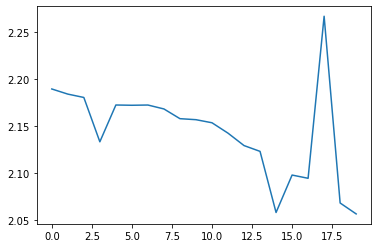

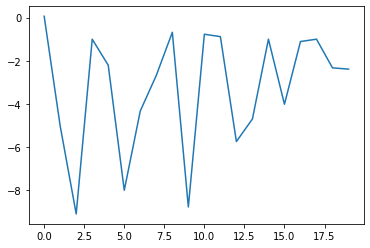

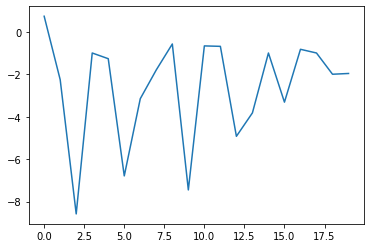

In [13]:
# Plotting results

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure()
plt.plot(stats1)
plt.figure()
plt.plot(stats2)
plt.figure()
plt.plot(stats3)

In [14]:
# Checking the network after training

s = np.asarray([-100, -200, -510, -50])

s = s/TW*2

s_v = torch.FloatTensor([s]).reshape(((1,4)))

next_step = net.forward(s_v)

print(np.round((next_step[0]).detach().numpy(),decimals=2))
print(np.round((next_step[0]).detach().numpy(),decimals=0))
print(np.argmax((next_step[0]).detach().numpy()))

[0.33 0.16 0.04 0.02 0.02 0.35 0.03 0.02 0.03]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
5


In [15]:
# Saving trained agent

import os

currentDirectory = os.getcwd()

torch.save(net.state_dict(), currentDirectory+"a.txt")

In [16]:
# Rendering
#import gym.wrappers
#env = gym.wrappers.Monitor(gym.make("steering_optimizer-v0"), directory="videos", force=True)
#net.generate_batch(env, 1, t_max=5000)
#env.close()